In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, optimize
import pickle

Queremos estudiar cómo se comportan los viajes en domingo respecto a los viajes en sábado, para esto vamos a usar los datos del STC metro:

In [19]:
datametro = pd.read_csv("D:/Edgar Trejo/Universidad/BioMatematica/Modeling COVID-19 Spreading in the ZMVM/data/rawdata/afluenciastc_simple_02_2023.csv",
                       parse_dates = [0], encoding = 'latin')

La EOD fue hecha en el año 2017, por ello usaremos los datos del metro de ese mismo año.

In [3]:
datametro = datametro[("2017-01-01" <= datametro['fecha'])&( datametro['fecha'] <= "2017-12-31")]

Agrupamos los datos por fecha y sumamos la afluencia de cada estación:

In [4]:
afluenciaporfecha = datametro.groupby("fecha")[['afluencia']].sum()

Obtenemos el día de la semana correspondiente a la fecha (lunes = 0, ...)

In [5]:
afluenciaporfecha['wd'] = afluenciaporfecha.index.dayofweek

Filtramos los datos de afluencia para los días sábado y domingo.

In [6]:
afluencia_sabdom = afluenciaporfecha[afluenciaporfecha.wd.isin([5, 6])]

Queremos emparejar los sábados y domingos de la misma semana. Podemos notar que el primer domingo no tiene un sábado para emparejar, por lo tanto eliminamos ese primer dato.

In [7]:
afluencia_sabdom = afluencia_sabdom.iloc[1:]

Los datos están ordenados por sus fechas. Creamos una lista con la semana correspondiente de cada par sábado-domingo y creamos una nueva columna en el data frame con esta.

In [8]:
weeks = []
for i in range(52):
    weeks.extend([i, i])

afluencia_sabdom['week'] = weeks

Pivoteamos el dataframe de forma que las columnas correspondan al tipo de día y los valores sean las afluencias registradas en cada semana.

In [9]:
afluenciaporsemana = afluencia_sabdom.pivot(columns = "wd", index = "week", values = "afluencia")
afluenciaporsemana.rename(columns = {5:'sab', 6:'dom'}, inplace = True)

In [10]:
afluenciaporsemana.head()

wd,sab,dom
week,,
0,3687821,2447948
1,4169682,2776097
2,4221637,2652035
3,4332793,2672735
4,4222117,2632123


Si vemos el boxplot de los datos, notamos la existencia de muchos outliers.

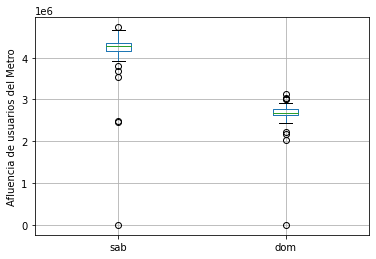

In [11]:
fig, ax = plt.subplots()

afluenciaporsemana.boxplot(ax = ax)
ax.set_ylabel("Afluencia de usuarios del Metro")

plt.show()

Queremos eliminar los registros de las semanas que presentan estos valores atípicos para alguno de los dos días. 

In [12]:
# funciones para obtenemos los cuantiles Q1, Q3
q1 = lambda x: np.quantile(x, 0.25)
q3 = lambda x: np.quantile(x, 0.75)

In [13]:
# obtenemos el rango intercuantil de cada columna
sabiqr, domiqr = afluenciaporsemana.apply(stats.iqr)
# obtenemos los cuantiles Q1 y Q3 de cada columna
sq1, dq1 = afluenciaporsemana.apply(q1)
sq3, dq3 = afluenciaporsemana.apply(q3)

In [14]:
# obtenemos los rangos intercuantiles de cada día
sabriqr = (sq1 - 1.5*sabiqr, sq3 + 1.5*sabiqr)
domriqr = (dq1 - 1.5*domiqr, dq3 + 1.5*domiqr)

Ya con los rangos intercuantiles de cada tipo de día, filtramos los registros que estén dentro del rango típico de los datos.

In [15]:
# quitamos los registros que presenten afluencias atípicas en sábado
filtradossab = afluenciaporsemana[(afluenciaporsemana['sab'] >= sabriqr[0]) & (afluenciaporsemana['sab'] <= sabriqr[1])]
# quitamos los registros que presenten afluencias atípicas en domingo
filtrado = filtradossab[(filtradossab['dom'] >= domriqr[0]) & (filtradossab['dom'] <= domriqr[1])]

Veamos el gráfico de dispersión de los datos sin outliers.

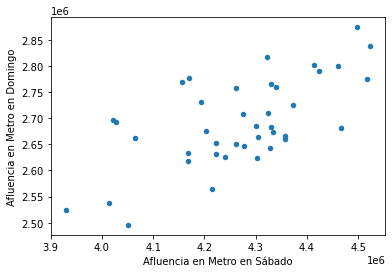

In [16]:
fig, ax = plt.subplots()

filtrado.plot.scatter(x = 'sab', y = 'dom', ax = ax)
ax.set_xlabel("Afluencia en Metro en Sábado")
ax.set_ylabel("Afluencia en Metro en Domingo")

plt.show()

Supongamos que $y = \beta x + \varepsilon$, donde $\varepsilon$ es una variable aleatoria. 

Obtenemos el ajuste de la recta:

In [22]:
ajuste = optimize.curve_fit(lambda x, b: b*x, xdata = filtrado['sab'], ydata = filtrado['dom'])
β = ajuste[0][0]

0.6303826278903926

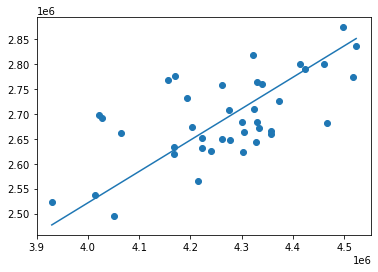

In [23]:
plt.scatter(filtrado['sab'], filtrado['dom'])
t = np.linspace(filtrado['sab'].min(), filtrado['sab'].max(), 100)
plt.plot(t, β*t)

plt.show()

Calculamos los errores de la aproximación lineal:

In [43]:
# valores predichos por el modelo lineal
ajuste = β*filtrado['sab']
# errores respecto a los datos reales
errores_rel = (filtrado['dom'] - ajuste)/filtrado['dom']

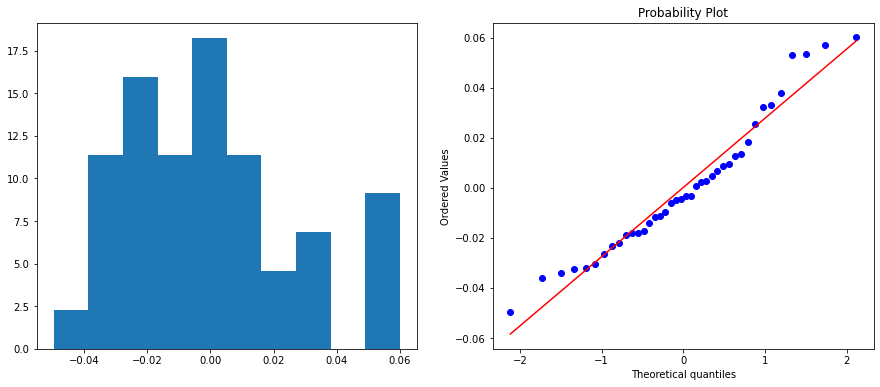

In [44]:
fig, ax = plt.subplots(1, 2)
ax[0].hist(errores_rel, density = True)
stats.probplot(errores_rel, dist="norm", plot = ax[1])

fig.set_size_inches(15, 6)
plt.show()

Vamos a suponer que los errores se distribuyen de manera normal. Vamos a realizar una serie de pruebas estadísticas:

In [45]:
# media y desv. estándar de la muestra
μ = errores_rel.mean()
σ = errores_rel.std()

In [48]:
with open("D:/Edgar Trejo/Universidad/BioMatematica/Modeling COVID-19 Spreading in the ZMVM/results/ajuste_sabdom.pkl", "wb") as handle:
    pickle.dump((β, μ, σ), handle, protocol=pickle.HIGHEST_PROTOCOL)

Realizamos dos pruebas: Una Shapiro-Wilk y otra Kolmogorov-Smirnov.

In [46]:
stats.shapiro(errores_rel)

ShapiroResult(statistic=0.9529921412467957, pvalue=0.09614597260951996)

In [47]:
stats.kstest(errores_rel, stats.norm.cdf, args=(μ,σ))

KstestResult(statistic=0.09938488498079218, pvalue=0.787926051067251)

El $p-$value de ambas pruebas es mayor a la significancia de $\alpha = 0.05$, por lo que no hay por qué rechazar nuestra hipótesis

Si $\mu^e$ es la media muestral de los errores y $\sigma^e$ es la d.e. de los erroes, entonces $$y = \beta x + \varepsilon $$

donde $\varepsilon \sim \mathcal N(\mu^e,\ \sigma^e)$.